# [hotsline](https://github.com/AntoineGrimaldi/hotsline) algorithm to replicate results from [this paper](https://www.techrxiv.org/articles/preprint/A_robust_event-driven_approach_to_always-on_object_recognition/18003077/1)
## Load events of the POKER_DVS dataset with [Tonic](https://tonic.readthedocs.io/en/latest/index.html)

/home/antoine/homhots/hotsline/hots
 Tonic version installed -> 1.0.15
number of samples in the trainset: 48
----------------------------------------
number of samples in each class for the trainset: [12. 12. 12. 12.]
----------------------------------------
number of samples in the dataset: 48


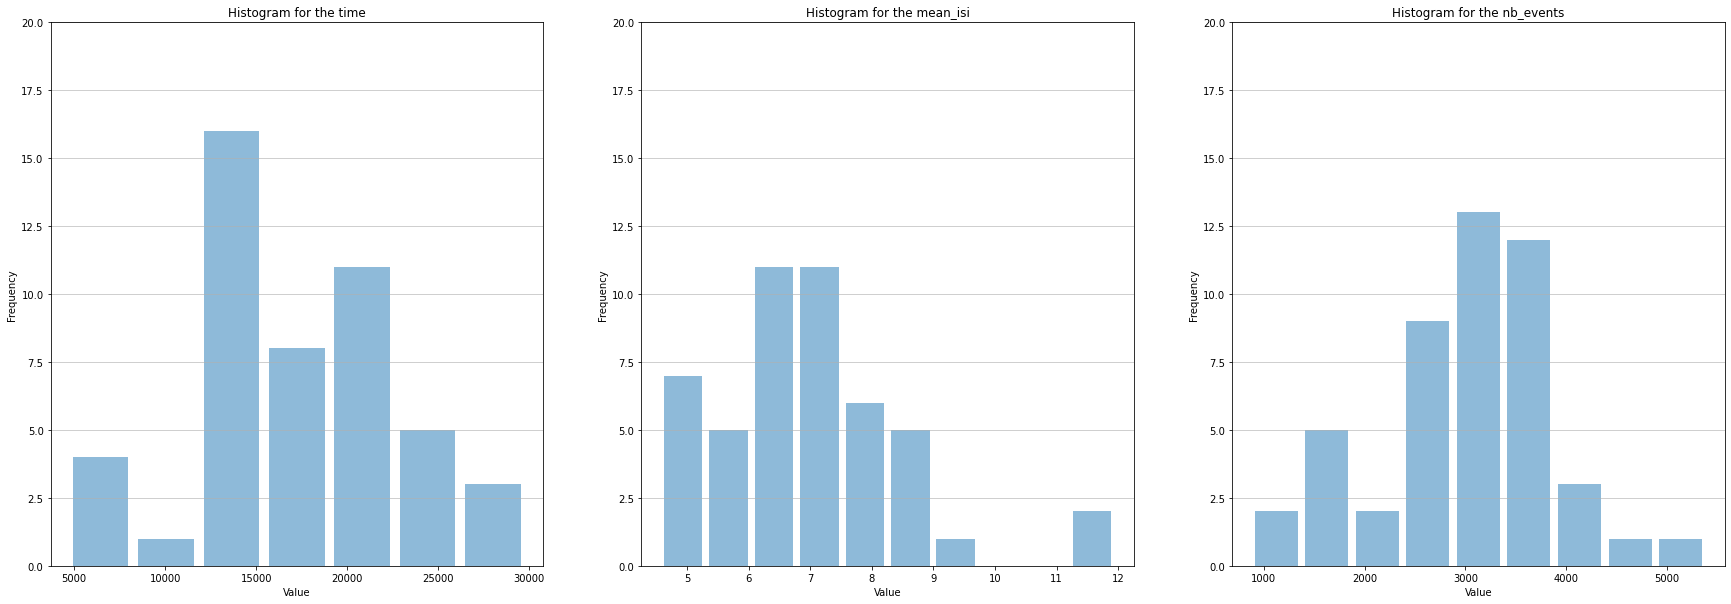

In [1]:
import tonic, torch, os
%cd ../hots
from utils import get_loader, get_dataset_info, HOTS_Dataset, make_histogram_classification
from network import network
from timesurface import timesurface

print(f' Tonic version installed -> {tonic.__version__}')

transform = tonic.transforms.NumpyAsType(int)
dataset = tonic.datasets.POKERDVS(save_to='../../Data/', train=True, transform=transform)
loader = get_loader(dataset)
get_dataset_info(dataset, properties = ['time', 'mean_isi', 'nb_events']);
print(f'number of samples in the dataset: {len(loader)}')

## Parameter tuning
### For the size of the time surface, we keep the same as the R chosen in HOTS and decide to increase R at each layer as done in the previous study by Lagorce et al. 
### Choice of a time constant for time surfaces sent as input of the network
Tau for the first layer is chosen empirically by measuring the entropy of the time surfaces sent as input of the network. For different tau, we measure the entropy of the time surfaces of the dataset and choose the given tau that maximizes this entropy value. 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

time_surface_size = (5,5)
tauz = np.arange(1,20,1)*1e2
entropy = []

loader = get_loader(dataset)
for events, target in tqdm(loader):
    for tau in tauz:
        TSs, indices = timesurface(events.squeeze(), dataset.sensor_size, dataset.ordering, tau = tau,  surface_dimensions=time_surface_size)
        entropy.append(-(TSs*torch.log(TSs)).mean(dim=(1,2,3)).nanmean().detach().cpu())

  0%|                                                                                                                                                                                                                                                  | 0/48 [00:04<?, ?it/s]


KeyboardInterrupt: 

Optimal tau: 0.8 ms


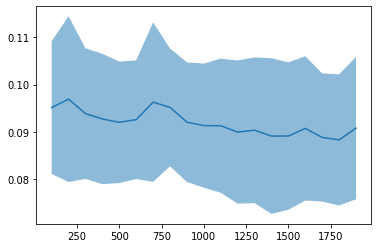

In [6]:
mean_ent = []
std_ent = []
for ind, tau in enumerate(tauz):
    entropy_tau = entropy[ind::48]
    mean_ent.append(np.nanmean(entropy_tau))
    std_ent.append(np.nanstd(entropy_tau))
    
plt.plot(tauz,mean_ent)
plt.fill_between(tauz, np.array(mean_ent)-np.array(std_ent), np.array(mean_ent)+np.array(std_ent), alpha = 0.5)

index = np.argmax(np.array(mean_ent)**2/np.array(std_ent))
print(f'Optimal tau: {tauz[index]*1e-3} ms')

### Choice of an architecture
Initial choice is to have an increased number of neurons with 3 layers. 

In [2]:
name = 'homeohots'
homeo = True
timestr = '2022-04-13'
dataset_name = 'poker'

Rz = (2, 4)
N_neuronz = (8, 16)
tauz = (.7e3, .7e3*8/2)

network = network(name, dataset_name, timestr, dataset.sensor_size, nb_neurons = N_neuronz, tau = tauz, R = Rz, homeo = homeo)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [02:18<00:00,  2.88s/it]


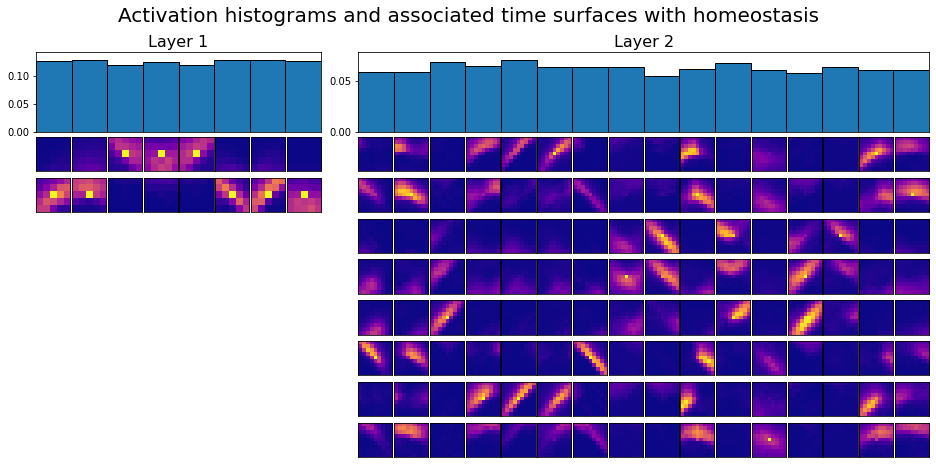

In [3]:
if not os.path.exists('../Records/'):
    os.mkdir('../Records/')
    os.mkdir('../Records/networks/')
filtering_threshold = [2*Rz[L] for L in range(len(Rz))]
path = '../Records/networks/'+network.name+'.pkl'
if not os.path.exists(path):
    network.clustering(loader, dataset.ordering, filtering_threshold)
network.plotlayers();

In [4]:
loader = get_loader(dataset, kfold = None, shuffle=True)
num_sample_train = len(dataset)
network.coding(loader, dataset.ordering, dataset.classes, filtering_threshold, training=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 48/48 [00:30<00:00,  1.56it/s]


In [5]:
dataset = tonic.datasets.POKERDVS(save_to='../../Data/', train=False, transform=transform)
num_sample_test = len(dataset)
loader = get_loader(dataset, kfold = None, shuffle=True)
network.coding(loader, dataset.ordering, dataset.classes, filtering_threshold, training=False)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:13<00:00,  1.48it/s]


In [6]:
from utils import make_histogram_classification, HOTS_Dataset

jitter = (None, None)

train_path = f'../Records/output/train/{network.name}_{num_sample_train}_{jitter}/'
test_path = f'../Records/output/test/{network.name}_{num_sample_test}_{jitter}/'

testset = HOTS_Dataset(test_path, dataset.sensor_size, transform=tonic.transforms.NumpyAsType(int))
trainset = HOTS_Dataset(train_path, dataset.sensor_size, transform=tonic.transforms.NumpyAsType(int))

In [7]:
score = make_histogram_classification(trainset, testset, N_neuronz[-1])
print(f' Accuracy: {score*100}%')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 1239.62it/s]

 Accuracy: 100.0%


## Rough parameters trial

In [17]:
import matplotlib.pyplot as plt

def plot_accuracy(scores, parameters, ind_param):
    paramlist = ['number of layers', 'R', 'tau', 'number of neurons']
    fig, ax = plt.subplots(figsize=(10,6))
    score_previous = 0
    for ind in range(len(scores)):
        score, tau = scores[ind], parameters[ind][ind_param]
        ax.plot(tau, score, '*', color='blue')
        ax.set_xlabel(paramlist[ind_param])
        ax.set_ylabel('accuracy')
        if score>score_previous:
            score_previous=score
            parameters_previous=parameters[ind]
    print(score_previous, parameters_previous)
    
def plot_accuracy_multi_param(scores, parameters):
    fig = plt.figure(figsize=(30,10))
    sub1 = fig.add_subplot(1,3,1, projection="3d")
    sub2 = fig.add_subplot(1,3,2, projection="3d")
    sub3 = fig.add_subplot(1,3,3, projection="3d")
    score_previous = 0
    colormap = plt.cm.get_cmap('summer_r', 10);
    for ind in range(len(scores)):
        score, lay, n_neuron, R = scores[ind], parameters[ind][0], parameters[ind][3], parameters[ind][1]
        sub1.scatter(n_neuron, lay, score, color=colormap(R/4), alpha=0.5)
        sub2.scatter(R, lay, score, color=colormap(n_neuron/16), alpha=0.5)
        sub3.scatter(n_neuron, R, score, color=colormap(lay/4), alpha=0.5)
        sub1.set_xlabel('neuron number')
        sub2.set_xlabel('R')
        sub3.set_xlabel('neuron number')
        sub1.set_ylabel('layer number')
        sub2.set_ylabel('layer number')
        sub3.set_ylabel('R')
        #sub1.view_init(10,-40)

1.0 [2, 2, 300.0, 16]
1.0 [2, 2, 300.0, 16]
1.0 [2, 2, 300.0, 16]
1.0 [2, 2, 300.0, 16]


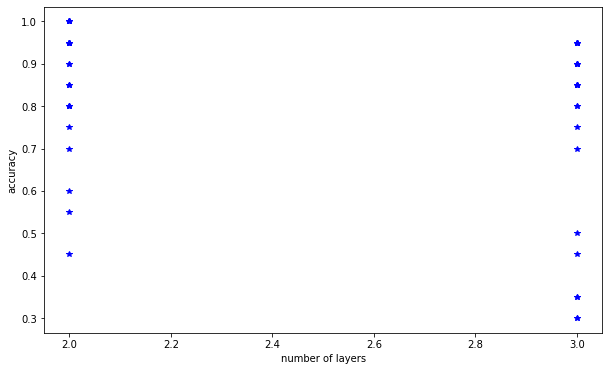

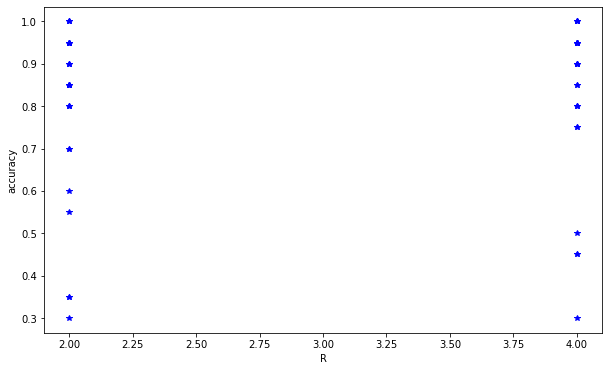

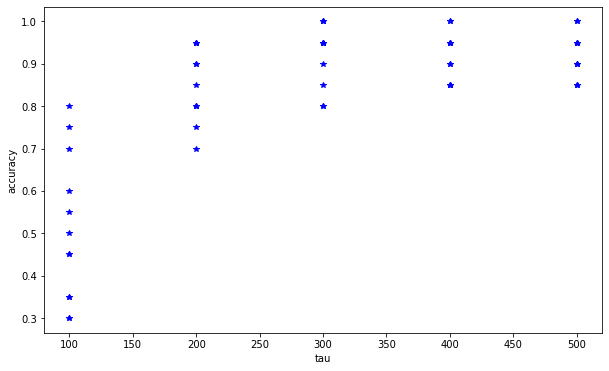

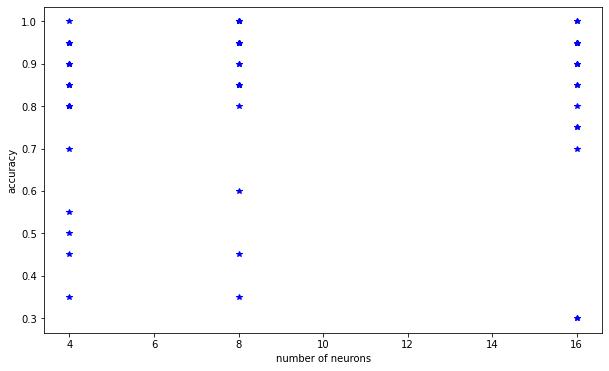

In [19]:
plot_accuracy(scores, parameters, 0)
plot_accuracy(scores, parameters, 1)
plot_accuracy(scores, parameters, 2)
plot_accuracy(scores, parameters, 3)

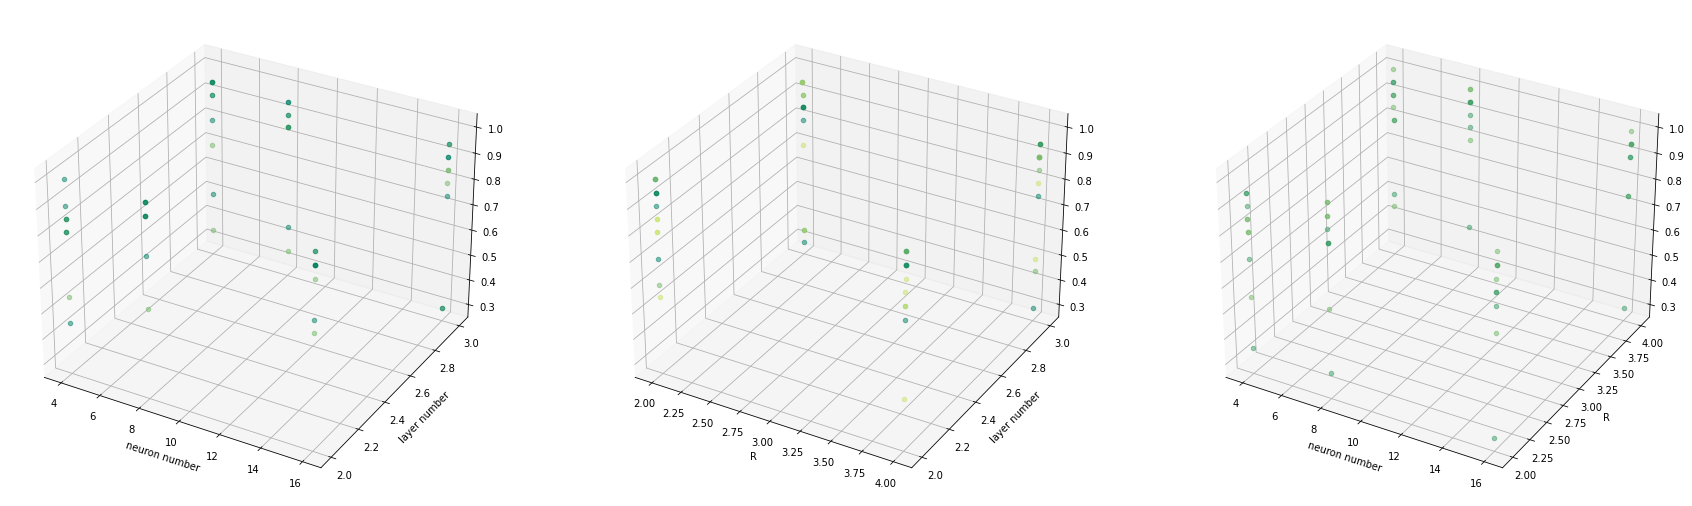

In [18]:
plot_accuracy_multi_param(scores, parameters)

In [ ]:
transform = tonic.transforms.NumpyAsType(int)
trainset = tonic.datasets.POKERDVS(save_to='../../Data/', train=True, transform=transform)
testset = tonic.datasets.POKERDVS(save_to='../../Data/', train=False, transform=transform)

name = 'homeohots'
homeo = True
timestr = '2022-04-22'
dataset_name = 'poker'

R_first = (2, 4)
N_layers = (2,3)#,4)
n_first = (4,8,16)
tau_first = (.1e3,.2e3,.3e3,.4e3,.5e3,.6e3,.7e3,.8e3,.9e3,1e4)

parameters = []
scores = []

for lay in N_layers:
    for R in R_first:
        for tau in tau_first:
            for N_neuron in n_first:
                Rz = [R*2**Nl for Nl in range(lay)]
                N_neuronz = [N_neuron*2**Nl for Nl in range(lay)]
                N_pola = N_neuronz.copy()
                N_pola.insert(0,2)
                tauz = [tau*N_pola[Nl+1]/N_pola[Nl] for Nl in range(lay-1)]
                tauz.insert(0,tau*2)
                hots = network(name, dataset_name, timestr, trainset.sensor_size, nb_neurons = N_neuronz, tau = tauz, R = Rz, homeo = homeo)
                filtering_threshold = [2*Rz[L] for L in range(len(Rz))]
                #clustering
                loader = get_loader(trainset)
                hots.clustering(loader, trainset.ordering, filtering_threshold)
                #training
                loader = get_loader(trainset)
                num_sample_train = len(loader)
                hots.coding(loader, trainset.ordering, trainset.classes, filtering_threshold, training=True)
                #testing
                loader = get_loader(testset)
                num_sample_test = len(loader)
                hots.coding(loader, trainset.ordering, trainset.classes, filtering_threshold, training=False)
                jitter = (None, None)

                train_path = f'../Records/output/train/{hots.name}_{num_sample_train}_{jitter}/'
                test_path = f'../Records/output/test/{hots.name}_{num_sample_test}_{jitter}/'

                testset_output = HOTS_Dataset(test_path, trainset.sensor_size, transform=tonic.transforms.NumpyAsType(int))
                trainset_output = HOTS_Dataset(train_path, trainset.sensor_size, transform=tonic.transforms.NumpyAsType(int))
                
                score = make_histogram_classification(trainset_output, testset_output, N_neuronz[-1]) 
                print(f' Accuracy: {score*100}%')
                
                parameters.append([lay, R, tau, N_neuron])
                scores.append(score)

this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_poker_homeohots_True_[4, 8]_[200.0, 200.0]_[2, 4]_48_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_poker_homeohots_True_[4, 8]_[200.0, 200.0]_[2, 4]_20_(None, None)/


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 710.13it/s]


 Accuracy: 55.00000000000001%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_poker_homeohots_True_[8, 16]_[200.0, 400.0]_[2, 4]_48_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_poker_homeohots_True_[8, 16]_[200.0, 400.0]_[2, 4]_20_(None, None)/


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 649.14it/s]

 Accuracy: 60.0%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_poker_homeohots_True_[16, 32]_[200.0, 800.0]_[2, 4]_48_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_poker_homeohots_True_[16, 32]_[200.0, 800.0]_[2, 4]_20_(None, None)/



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 704.56it/s]


 Accuracy: 70.0%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_poker_homeohots_True_[4, 8]_[400.0, 400.0]_[2, 4]_48_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_poker_homeohots_True_[4, 8]_[400.0, 400.0]_[2, 4]_20_(None, None)/


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 788.64it/s]


 Accuracy: 80.0%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_poker_homeohots_True_[8, 16]_[400.0, 800.0]_[2, 4]_48_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_poker_homeohots_True_[8, 16]_[400.0, 800.0]_[2, 4]_20_(None, None)/


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 798.92it/s]


 Accuracy: 95.0%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_poker_homeohots_True_[16, 32]_[400.0, 1600.0]_[2, 4]_48_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_poker_homeohots_True_[16, 32]_[400.0, 1600.0]_[2, 4]_20_(None, None)/


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 792.65it/s]


 Accuracy: 90.0%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_poker_homeohots_True_[4, 8]_[600.0, 600.0]_[2, 4]_48_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_poker_homeohots_True_[4, 8]_[600.0, 600.0]_[2, 4]_20_(None, None)/


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 794.60it/s]


 Accuracy: 80.0%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_poker_homeohots_True_[8, 16]_[600.0, 1200.0]_[2, 4]_48_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_poker_homeohots_True_[8, 16]_[600.0, 1200.0]_[2, 4]_20_(None, None)/


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 789.59it/s]


 Accuracy: 95.0%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_poker_homeohots_True_[16, 32]_[600.0, 2400.0]_[2, 4]_48_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_poker_homeohots_True_[16, 32]_[600.0, 2400.0]_[2, 4]_20_(None, None)/


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 842.31it/s]


 Accuracy: 100.0%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_poker_homeohots_True_[4, 8]_[800.0, 800.0]_[2, 4]_48_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_poker_homeohots_True_[4, 8]_[800.0, 800.0]_[2, 4]_20_(None, None)/


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 786.02it/s]


 Accuracy: 85.0%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_poker_homeohots_True_[8, 16]_[800.0, 1600.0]_[2, 4]_48_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_poker_homeohots_True_[8, 16]_[800.0, 1600.0]_[2, 4]_20_(None, None)/


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 777.53it/s]


 Accuracy: 100.0%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_poker_homeohots_True_[16, 32]_[800.0, 3200.0]_[2, 4]_48_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_poker_homeohots_True_[16, 32]_[800.0, 3200.0]_[2, 4]_20_(None, None)/


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 793.56it/s]


 Accuracy: 95.0%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_poker_homeohots_True_[4, 8]_[1000.0, 1000.0]_[2, 4]_48_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_poker_homeohots_True_[4, 8]_[1000.0, 1000.0]_[2, 4]_20_(None, None)/


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 785.14it/s]


 Accuracy: 85.0%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_poker_homeohots_True_[8, 16]_[1000.0, 2000.0]_[2, 4]_48_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_poker_homeohots_True_[8, 16]_[1000.0, 2000.0]_[2, 4]_20_(None, None)/


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 790.48it/s]


 Accuracy: 100.0%
this dataset have already been processed, check at: 
 ../Records/output/train/2022-04-22_poker_homeohots_True_[16, 32]_[1000.0, 4000.0]_[2, 4]_48_(None, None)/
this dataset have already been processed, check at: 
 ../Records/output/test/2022-04-22_poker_homeohots_True_[16, 32]_[1000.0, 4000.0]_[2, 4]_20_(None, None)/


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 789.94it/s]


 Accuracy: 95.0%


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 567.63it/s]


 Accuracy: 90.0%


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 782.83it/s]


 Accuracy: 100.0%


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 637.68it/s]


 Accuracy: 95.0%


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 750.69it/s]


 Accuracy: 90.0%


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 671.72it/s]


 Accuracy: 95.0%


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 746.68it/s]


 Accuracy: 95.0%


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 744.71it/s]


 Accuracy: 75.0%


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 663.02it/s]


 Accuracy: 100.0%


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 41/48 [01:01<00:09,  1.41s/it]